# C. Freshness detector

In [8]:
import pandas as pd
import numpy as np
import utils.matplotlib_init
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.pipeline import Pipeline, TransformerMixin, FeatureUnion
from sklearn.base import BaseEstimator
from lightgbm import LGBMClassifier

In [2]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.columns]

In [3]:
data_train = pd.read_csv('input/c_train.tsv', sep='\t')
data_test = pd.read_csv('input/c_test.tsv', sep='\t')
data = pd.concat((data_train, data_test))
data['train'] = data.fresh_click.notnull()
data['timestamp'] = pd.to_datetime(data.timestamp, unit='s') + pd.to_timedelta(3, unit='h')
data['day'] = data.timestamp.dt.day
data['hour'] = data.timestamp.dt.hour
data['minute'] = data.timestamp.dt.minute

Let's see what is the percentage of fresh clicks in the whole dataset

In [4]:
data_train.fresh_click.mean()

0.072084

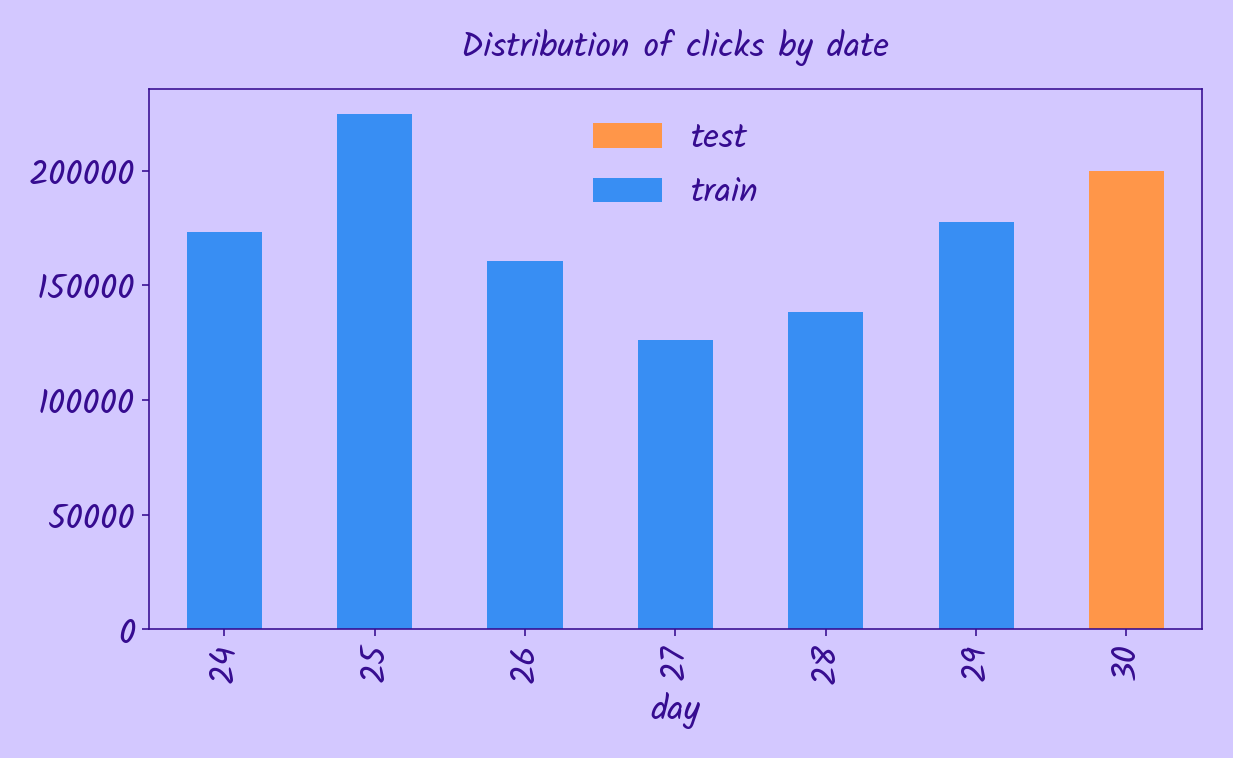

In [15]:
ax = data.groupby('train').day.value_counts().unstack(0) \
    .plot(kind='bar', stacked=True, title='Distribution of clicks by date', color=['#FF9649', '#388EF3'])
ax.legend(['test', 'train'])
ax.figure.tight_layout(pad=1.5)

We see that we learn on past clicks and should predict for the next day. So for validation we can train on
days **24-28** and validate on **29**

First, let's try basic features without considering query text at all

In [8]:
pipeline_without_text = Pipeline([
    ('select', ColumnSelector(['requests_per_prev_1_hour', 'requests_per_prev_2_hour', 'requests_per_prev_6_hour', 
                                     'requests_per_prev_12_hour', 'requests_per_prev_24_hour',
                                     'requests_per_prev_72_hour', 'hour', 'minute'])),
    ('clf', LGBMClassifier(n_estimators=100, class_weight='balanced'))
])

pipeline_without_text.fit(data[data.day < 29], data[data.day < 29].fresh_click)
predicted = pipeline_without_text.predict(data[data.day == 29])
metrics.f1_score(data[data.day == 29].fresh_click, predicted, average='binary')

0.1660215956651229

Okay, we got *~0.17* that is below required threshold *0.25*, so probably we should take query text into account as 
well. Let's build pipeline using **TfidfVectorizer** to extract words usage statistics from queries

In [10]:
pipeline_with_text = Pipeline([
    ('features', 
    FeatureUnion([
        ('tfidf', 
          Pipeline([
                ('selector', ColumnSelector('query')),
                ('tfidf', TfidfVectorizer(token_pattern=r'\b\d+\b')),
            ])),
        ('original', ColumnSelector(['requests_per_prev_1_hour', 'requests_per_prev_6_hour', 
                                     'requests_per_prev_12_hour', 'requests_per_prev_24_hour',
                                     'requests_per_prev_72_hour', 'hour', 'minute']))])),
    ('clf', LGBMClassifier(n_estimators=100, class_weight='balanced'))
])
               
pipeline_with_text.fit(data[data.day < 29], data[data.day < 29].fresh_click)
predicted = pipeline_with_text.predict(data[data.day == 29])
metrics.f1_score(data[data.day == 29].fresh_click, predicted)

0.28560253052617257

Hurray! We've got F1-score above minimal threshold *0.25*. Now let's submit!

In [14]:
np.savetxt('output/c.out', predicted, '%d')